In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader, Dataset, sampler
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

['IdLookupTable.csv', 'test', 'SampleSubmission.csv', 'training']


In [2]:
lookup = pd.read_csv('../input/IdLookupTable.csv')
sample = pd.read_csv('../input/SampleSubmission.csv')
print(lookup.head())
print(sample.head())

   RowId  ImageId              FeatureName  Location
0      1        1        left_eye_center_x       NaN
1      2        1        left_eye_center_y       NaN
2      3        1       right_eye_center_x       NaN
3      4        1       right_eye_center_y       NaN
4      5        1  left_eye_inner_corner_x       NaN
   RowId  Location
0      1         0
1      2         0
2      3         0
3      4         0
4      5         0


- load data to kernel
- create dataloader to iterate over for training
- visualize data to familiarize myself with it
- define architectures to examine
- define training function
- defince accuracy check function
- define list of hyperparameters to iterate over 
- test model with 0 input
- overfit model with small dataset
- iterate over hyperparameters to obtain best performing model with few epochs
- train model with many epochs

In [3]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='x', s=10)


                                                                           0                        ...                                                                          4
left_eye_center_x                                                    66.0336                        ...                                                                    66.7253
left_eye_center_y                                                    39.0023                        ...                                                                    39.6213
right_eye_center_x                                                    30.227                        ...                                                                    32.2448
right_eye_center_y                                                   36.4217                        ...                                                                     38.042
left_eye_inner_corner_x                                              59.5821                        ...  

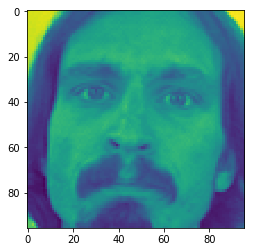

In [4]:
# view format of data
train_df = pd.read_csv('../input/training/training.csv')
print(train_df.head().T)
im = np.array(train_df.Image[0].split(), dtype=int)
dim_im = int(np.sqrt(im.shape[0]))
plt.imshow(im.reshape(dim_im, dim_im))
print(dim_im)

In [5]:
dtype = torch.float32
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [6]:
class dataset(Dataset):
    def __init__(self, train=True):
        self.train = train
        if train:
            train_df = pd.read_csv('../input/training/training.csv')
            train_df.dropna(inplace=True)           
            train_images = np.array([np.fromstring(img, dtype=np.int16, sep=' ') for img in train_df.Image])
            N, D = train_images.shape
            D_sqrt = int(np.sqrt(D))
            # na_filter = train_df.isna().values
            # train_vals = train_df.values
            # train_vals[na_filter] = 0
            # train_keypoints = train_vals[:, :-1].astype(float)
            train_keypoints = train_df.values[:, :-1].astype(float)
            self.train_images = train_images.reshape(N, 1, D_sqrt, D_sqrt)
            self.train_keypoints = train_keypoints
            self.len = N
            return
        test_df = pd.read_csv('../input/test/test.csv')
        test_images = np.array([np.fromstring(img, dtype=np.int16, sep=' ') for img in test_df.Image])
        N, D = test_images.shape
        D_sqrt = int(np.sqrt(D))
        self.test_images = test_images.reshape(N, 1, D_sqrt, D_sqrt)
        self.test_imageID = test_df.ImageId.values
        self.len = N

    def __getitem__(self, index):
        if self.train:
            return torch.tensor(self.train_images[index], device=device, dtype=dtype), torch.tensor(self.train_keypoints[index], device=device, dtype=dtype)
        else:
            return torch.tensor(self.test_images[index], device=device, dtype=dtype)
        
    def __len__(self):
        return self.len

BATCH = 32
train_dataset = dataset(train=True)
test_dataset = dataset(train=False)
N_data = train_dataset.len
N_train = int(N_data * 0.8)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH, sampler=sampler.SubsetRandomSampler(range(N_train)))
overfit_loader = DataLoader(dataset=train_dataset, batch_size=BATCH, sampler=sampler.SubsetRandomSampler(range(N_train)))
val_loader = DataLoader(dataset=train_dataset, batch_size=BATCH, sampler=sampler.SubsetRandomSampler(range(N_train, N_data)))
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH, shuffle=True)

In [7]:
class flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv0 = torch.nn.Conv2d(1, 256, 3, padding=1)
        self.conv1 = torch.nn.Conv2d(256, 128, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 32, 3, padding=1)
        self.batch_norm0 = torch.nn.BatchNorm2d(256)
        self.batch_norm1 = torch.nn.BatchNorm2d(128)
        self.batch_norm2 = torch.nn.BatchNorm2d(64)
        self.batch_norm3 = torch.nn.BatchNorm2d(32)
        self.lin1 = torch.nn.Linear(96*96*32, 1000)
        self.lin2 = torch.nn.Linear(1000, 30)
        self.flatten = flatten()
        
    def forward(self, x):
        x = F.relu(self.batch_norm0(self.conv0(x)))
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

lr = 0.001
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
schedualer = optim.lr_scheduler.StepLR(optimizer, 30)

In [8]:
def train(model, optimizer, epochs=100):
    for e in range(epochs):
        model.to(device=device)
        for t, (train_images, train_keypoints) in enumerate(train_loader):
            model.train()
            predic_keypoints = model(train_images)
            loss = F.mse_loss(predic_keypoints, train_keypoints)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if t % 50 == 0:
                print ('epoch {0}, iteration {1}, loss = {2}'.format(e, t, loss.item()))
                check_accuracy(model, val_loader)
                print('cuda memory allocated %d' %torch.cuda.memory_allocated())
                print()
    return loss
                
def check_accuracy(model, loader):
    dist_tol = 10
    model.eval()
    num_correct = 0
    num_keypoints = 0
    for data, keypoints in loader:
        pred = model(data)
        diffs_squared = (pred - keypoints).pow_(2)
        dist_squared = diffs_squared[:, range(0,29,2)] + diffs_squared[:, range(1,30,2)]
        num_correct += (dist_squared < dist_tol).sum()
        num_keypoints += 15*keypoints.size(0)
    acc = float(num_correct) / num_keypoints
    print('Got %d / %d correct (%.2f)' % (num_correct, num_keypoints, 100*acc))

In [9]:
"""
loss = 1000000
best_lr = 1
for scale in range(4,9):
    lr = 10**-scale
    print(lr)
    model = Model()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    new_loss = train(model, optimizer, epochs = 2)
    if new_loss < loss:
        loss = new_loss
        best_lr = lr
        print('best lr is %f' %best_lr)
"""

"\nloss = 1000000\nbest_lr = 1\nfor scale in range(4,9):\n    lr = 10**-scale\n    print(lr)\n    model = Model()\n    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)\n    new_loss = train(model, optimizer, epochs = 2)\n    if new_loss < loss:\n        loss = new_loss\n        best_lr = lr\n        print('best lr is %f' %best_lr)\n"

In [10]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.01)
train(model, optimizer)

epoch 0, iteration 0, loss = 2626.69482421875
Got 0 / 6420 correct (0.00)
cuda memory allocated 3545209856

epoch 0, iteration 50, loss = 14.076998710632324
Got 402 / 6420 correct (6.26)
cuda memory allocated 3545209856

epoch 1, iteration 0, loss = 11.038843154907227
Got 406 / 6420 correct (6.32)
cuda memory allocated 3545209856

epoch 1, iteration 50, loss = 8.519237518310547
Got 2105 / 6420 correct (32.79)
cuda memory allocated 3545209856

epoch 2, iteration 0, loss = 8.902743339538574
Got 1933 / 6420 correct (30.11)
cuda memory allocated 3545209856

epoch 2, iteration 50, loss = 7.55430793762207
Got 2123 / 6420 correct (33.07)
cuda memory allocated 3545209856

epoch 3, iteration 0, loss = 11.199457168579102
Got 1968 / 6420 correct (30.65)
cuda memory allocated 3545209856

epoch 3, iteration 50, loss = 7.12636137008667
Got 1968 / 6420 correct (30.65)
cuda memory allocated 3545209856

epoch 4, iteration 0, loss = 7.987980365753174
Got 2160 / 6420 correct (33.64)
cuda memory allocated

epoch 36, iteration 0, loss = 4.027216911315918
Got 2914 / 6420 correct (45.39)
cuda memory allocated 3545209856

epoch 36, iteration 50, loss = 2.404050588607788
Got 2902 / 6420 correct (45.20)
cuda memory allocated 3545209856

epoch 37, iteration 0, loss = 3.457646369934082
Got 2802 / 6420 correct (43.64)
cuda memory allocated 3545209856

epoch 37, iteration 50, loss = 2.3426873683929443
Got 2899 / 6420 correct (45.16)
cuda memory allocated 3545209856

epoch 38, iteration 0, loss = 2.1083691120147705
Got 2944 / 6420 correct (45.86)
cuda memory allocated 3545209856

epoch 38, iteration 50, loss = 3.0096890926361084
Got 2964 / 6420 correct (46.17)
cuda memory allocated 3545209856

epoch 39, iteration 0, loss = 4.469358444213867
Got 2918 / 6420 correct (45.45)
cuda memory allocated 3545209856

epoch 39, iteration 50, loss = 2.9045512676239014
Got 2968 / 6420 correct (46.23)
cuda memory allocated 3545209856

epoch 40, iteration 0, loss = 3.489513874053955
Got 2849 / 6420 correct (44.38)


Got 3387 / 6420 correct (52.76)
cuda memory allocated 3545209856

epoch 72, iteration 0, loss = 1.3975437879562378
Got 3393 / 6420 correct (52.85)
cuda memory allocated 3545209856

epoch 72, iteration 50, loss = 2.982130765914917
Got 3400 / 6420 correct (52.96)
cuda memory allocated 3545209856

epoch 73, iteration 0, loss = 2.370763063430786
Got 3372 / 6420 correct (52.52)
cuda memory allocated 3545209856

epoch 73, iteration 50, loss = 1.6541668176651
Got 3367 / 6420 correct (52.45)
cuda memory allocated 3545209856

epoch 74, iteration 0, loss = 1.4703655242919922
Got 3381 / 6420 correct (52.66)
cuda memory allocated 3545209856

epoch 74, iteration 50, loss = 1.8395843505859375
Got 3434 / 6420 correct (53.49)
cuda memory allocated 3545209856

epoch 75, iteration 0, loss = 1.266808271408081
Got 3449 / 6420 correct (53.72)
cuda memory allocated 3545209856

epoch 75, iteration 50, loss = 1.4497214555740356
Got 3428 / 6420 correct (53.40)
cuda memory allocated 3545209856

epoch 76, iterat

tensor(1.3240, device='cuda:0', grad_fn=<MseLossBackward>)

In [11]:
model.eval()
pred_keypoint = pd.DataFrame(columns=train_df.columns[:-1], index=list(range(1, test_dataset.len+1)))
for b, test_im in enumerate(test_loader):
    pred = model(test_im)
    pred_cpu = pred.cpu()
    pred_keypoint.loc[1+b*BATCH:(b+1)*BATCH, :] = pred_cpu.detach().numpy()


In [12]:
submit_np = pred_keypoint.values
submit_np = submit_np.reshape(-1)
submit_df = pd.DataFrame(columns=['RowId', 'Location'])
submit_df.RowId = list(range(1, len(submit_np)+1))
submit_df.Location = submit_np

In [13]:
submit_df.to_csv('submission.csv')

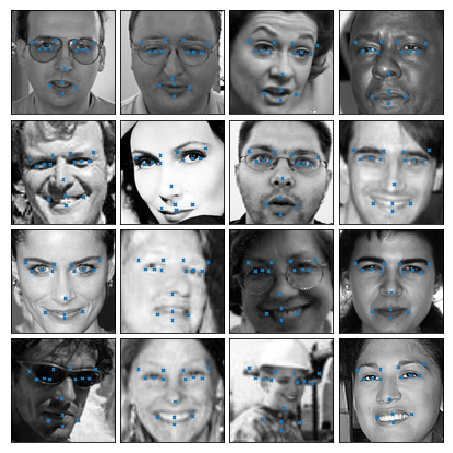

In [14]:
X = test_im.cpu()
X = X.detach().numpy()
y_pred = pred_cpu.detach().numpy()

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()
